In [1]:
import fastai
from fastai import *
from fastai.vision import *

In [2]:
path = Path("F:\\data\\fastai\\CamVid")

In [3]:
path.ls()

[WindowsPath('F:/data/fastai/CamVid/models'),
 WindowsPath('F:/data/fastai/CamVid/test'),
 WindowsPath('F:/data/fastai/CamVid/test.txt'),
 WindowsPath('F:/data/fastai/CamVid/testannot'),
 WindowsPath('F:/data/fastai/CamVid/train'),
 WindowsPath('F:/data/fastai/CamVid/train.txt'),
 WindowsPath('F:/data/fastai/CamVid/trainannot'),
 WindowsPath('F:/data/fastai/CamVid/val'),
 WindowsPath('F:/data/fastai/CamVid/val.txt'),
 WindowsPath('F:/data/fastai/CamVid/valannot')]

#### 观察数据

In [4]:
fnames = get_image_files(path/'val')

In [5]:
fnames[:3]

[WindowsPath('F:/data/fastai/CamVid/val/0016E5_07959.png'),
 WindowsPath('F:/data/fastai/CamVid/val/0016E5_07961.png'),
 WindowsPath('F:/data/fastai/CamVid/val/0016E5_07963.png')]

In [6]:
lbl_fnames = get_image_files(path/'valannot')
lbl_fnames[:3]

[WindowsPath('F:/data/fastai/CamVid/valannot/0016E5_07959.png'),
 WindowsPath('F:/data/fastai/CamVid/valannot/0016E5_07961.png'),
 WindowsPath('F:/data/fastai/CamVid/valannot/0016E5_07963.png')]

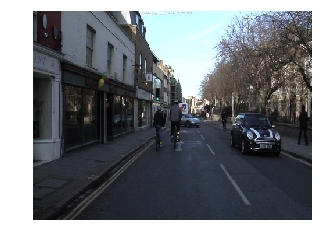

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name
codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

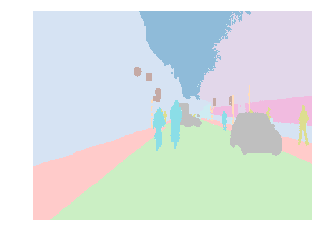

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5))

In [10]:
src_data = np.array(mask.shape[1:])
src_data,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

#### 开始训练

In [11]:
bs,size = 8,src_data//2

In [12]:
size

array([180, 240], dtype=int32)

In [13]:
src = SegmentationItemList.from_folder(path).split_by_folder(valid='val').label_from_func(get_y_fn,classes = codes)

In [14]:
data = (src.transform(get_transforms(),size = size,tfm_y = True).databunch(bs = bs).normalize(imagenet_stats))

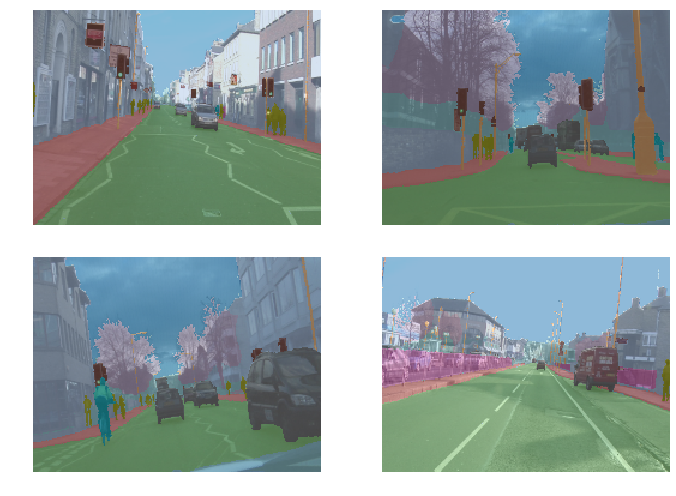

In [15]:
data.show_batch(2,figsize=(10,7))

In [16]:
data.one_item

<bound method DataBunch.one_item of ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (367 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: F:\data\fastai\CamVid
x: SegmentationItemList (367 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: F:\data\fastai\CamVid;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: F:\data\fastai\CamVid
x: SegmentationItemList (101 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: F:\data\fastai\CamVid;

Test: None>

#### 创建learner

In [17]:
name2id = {v:k for k,v in enumerate(codes)}

In [18]:
void_code = name2id['Void']

In [19]:
void_code

11

In [20]:
def acc_camvid(input,target):
    target = target.squeeze(1)
    mask = target!=void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
learner = unet_learner(data,arch=models.resnet18,metrics=acc_camvid,wd = 1e-2,bottle=True)

In [22]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


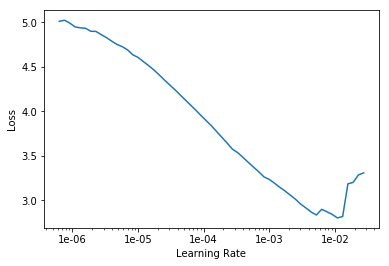

In [23]:
learner.recorder.plot()

In [24]:
lr = 2e-3 

In [25]:
learner.fit_one_cycle(5,slice(lr),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,1.363548,0.887998,0.756106
2,0.903477,0.631286,0.823470
3,0.841881,0.877946,0.772635
4,0.727488,0.532497,0.862761
5,0.581763,0.460579,0.868987


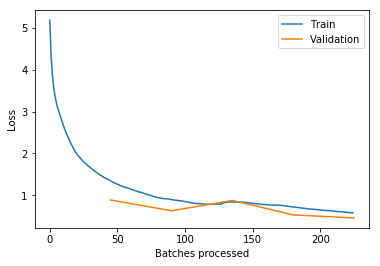

In [26]:
learner.recorder.plot_losses()

In [28]:
learner.save('stage-1')

In [29]:
learner.fit_one_cycle(5,slice(lr),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.448529,0.455784,0.867782
2,0.444045,0.434577,0.865014
3,0.437159,0.450020,0.858138
4,0.454985,0.412552,0.871786
5,0.423111,0.349355,0.884001


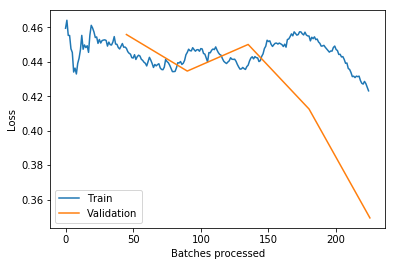

In [31]:
learner.recorder.plot_losses()

In [32]:
learner.save("stage-2")

In [33]:
learner.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (367 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: F:\data\fastai\CamVid
x: SegmentationItemList (367 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: F:\data\fastai\CamVid;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: F:\data\fastai\CamVid
x: SegmentationItemList (101 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: F:\data\fastai\CamVid;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    

In [34]:
learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 64, 90, 120]     9408       False     
______________________________________________________________________
BatchNorm2d          [8, 64, 90, 120]     128        True      
______________________________________________________________________
ReLU                 [8, 64, 90, 120]     0          False     
______________________________________________________________________
MaxPool2d            [8, 64, 45, 60]      0          False     
______________________________________________________________________
Conv2d               [8, 64, 45, 60]      36864      False     
______________________________________________________________________
BatchNorm2d          [8, 64, 45, 60]      128        True      
______________________________________________________________________
ReLU                 [8, 64, 45, 60]      0          False     
______________________________________________________________

AvgPool2d            [8, 256, 12, 16]     0          False     
______________________________________________________________________
ReLU                 [8, 1024, 6, 8]      0          False     
______________________________________________________________________
BatchNorm2d          [8, 256, 12, 15]     512        True      
______________________________________________________________________
Conv2d               [8, 512, 12, 15]     2359808    True      
______________________________________________________________________
ReLU                 [8, 512, 12, 15]     0          False     
______________________________________________________________________
Conv2d               [8, 512, 12, 15]     2359808    True      
______________________________________________________________________
ReLU                 [8, 512, 12, 15]     0          False     
______________________________________________________________________
ReLU                 [8, 512, 12, 15]     0          Fa

In [35]:
learner.unfreeze()

In [36]:
learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 64, 90, 120]     9408       True      
______________________________________________________________________
BatchNorm2d          [8, 64, 90, 120]     128        True      
______________________________________________________________________
ReLU                 [8, 64, 90, 120]     0          False     
______________________________________________________________________
MaxPool2d            [8, 64, 45, 60]      0          False     
______________________________________________________________________
Conv2d               [8, 64, 45, 60]      36864      True      
______________________________________________________________________
BatchNorm2d          [8, 64, 45, 60]      128        True      
______________________________________________________________________
ReLU                 [8, 64, 45, 60]      0          False     
______________________________________________________________

AvgPool2d            [8, 256, 12, 16]     0          False     
______________________________________________________________________
ReLU                 [8, 1024, 6, 8]      0          False     
______________________________________________________________________
BatchNorm2d          [8, 256, 12, 15]     512        True      
______________________________________________________________________
Conv2d               [8, 512, 12, 15]     2359808    True      
______________________________________________________________________
ReLU                 [8, 512, 12, 15]     0          False     
______________________________________________________________________
Conv2d               [8, 512, 12, 15]     2359808    True      
______________________________________________________________________
ReLU                 [8, 512, 12, 15]     0          False     
______________________________________________________________________
ReLU                 [8, 512, 12, 15]     0          Fa

In [37]:
lrs = slice(lr/100,lr)

In [38]:
learner.fit_one_cycle(5,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid


RuntimeError: CUDA out of memory. Tried to allocate 130.63 MiB (GPU 0; 4.00 GiB total capacity; 2.34 GiB already allocated; 21.03 MiB free; 716.45 MiB cached)